<h1 align="center" style="background-color:#616161;color:white">When do people listen to music?</h1>

In [1]:
# import modules
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import datetime
import csv
import json
import sqlite3
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import gensim, logging

## Parameters you can change

# Abs path to settings file
#root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
root = "/home/badrul/Documents/github/MusicRecommendation" # BA, Linux

## Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

import coreCode as cb
import lastfmCode as fm

## Finish setting up
os.chdir(root)

settingsDict =  cb.loadSettings()

dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']


<h3 style="background-color:#616161;color:white">1. Overall picture of when people start listening to music</h3>

Based on the earlier preliminary analysis we chose the 'start' of a listening session as when people listen to music aftere an interval of more than 10 minutes.

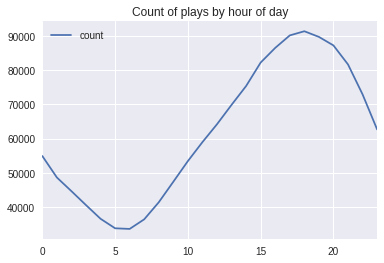

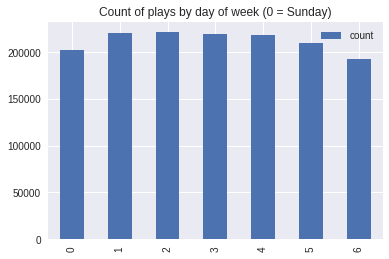

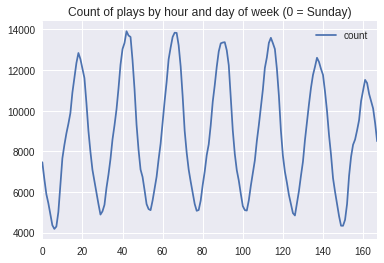

In [257]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(dbPath)
hours = pd.read_sql_query("Select strftime('%H',PlayedTimestamp) as hourOfWeek, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > 10 group by hourOfWeek", con)
week = pd.read_sql_query("Select strftime('%w',PlayedTimestamp) as hourOfWeek, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > 10 group by hourOfWeek", con)
hrwk = pd.read_sql_query("Select strftime('%w',PlayedTimestamp) || '-' || strftime('%H',PlayedTimestamp) as timeSlot, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > 10 group by timeSlot", con)
con.close()

hours.plot(title='Count of plays by hour of day')
week.plot.bar(title='Count of plays by day of week (0 = Sunday)')
hrwk.plot(title='Count of plays by hour and day of week (0 = Sunday)')

<b>Conclusion</b>

* People listen to music more during the week than on weekends
* There is a predictable pattern to the time of day that people listen to music, at leasat at this aggregate level
* Daytime hours are the most popular time to listen to music, peaking in the early evening / after-work hours

<h3 style="background-color:#616161;color:white">2. Construct the Play Timetable in the db</h3>

In [289]:
import time

minForNewSession = 10

con = sqlite3.connect(dbPath)
con.row_factory = sqlite3.Row
cursor = con.cursor()
# Perform sql query to bring back the right results, use pandas to pivot to the right form, then save back into db
sqlStr = "Select UserID, strftime('%w',PlayedTimestamp) || '-' || strftime('%H',PlayedTimestamp) as TimeSlot, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > {} group by TimeSlot, UserID".format(minForNewSession)
df = pd.read_sql_query(sqlStr, con)
df=df.set_index('UserID')
#df=df.pivot(index='UserID', columns='TimeSlot', values='count')
df.to_sql('tblPlayTimetable',con,if_exists='replace')

con.close()

<h3 style="background-color:#616161;color:white">3. Let's check our newly constructed Play Timetable agrees</h3>

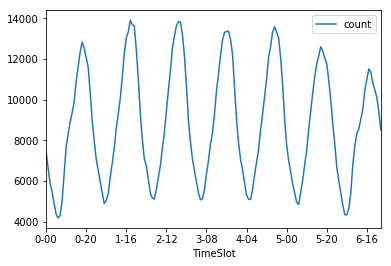

In [2]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(dbPath)
df = pd.read_sql_query("SELECT * from tblPlayTimetable", con)
df=df.set_index('UserID')
con.close()

total = df.groupby(['TimeSlot']).sum()
total.plot()

<h3 style="background-color:#616161;color:white">4. Ok now let's analyze by users</h3>

This is what our table looks like

In [4]:
df.head()

,TimeSlot,count
UserID,,
1,0-00,4
2,0-00,2
3,0-00,17
4,0-00,11
5,0-00,16


<b>Let's plot a few individual users</b>

/home/badrul/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/home/badrul/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


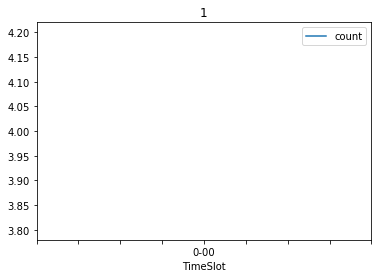

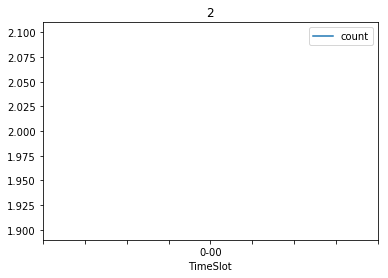

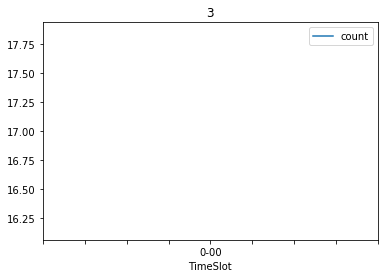

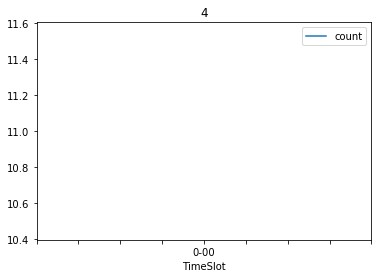

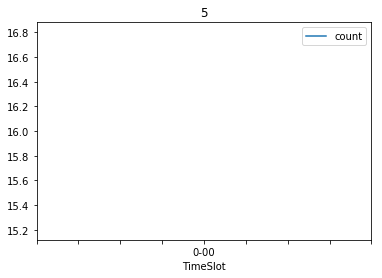

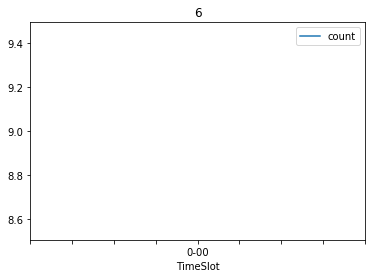

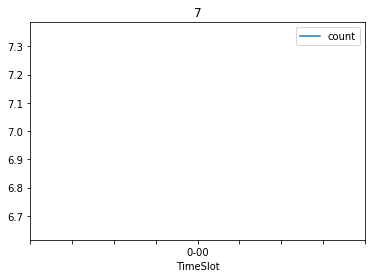

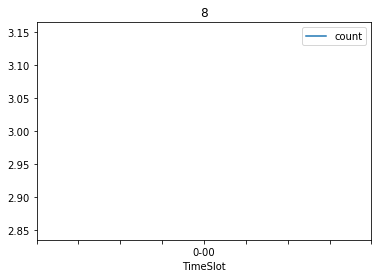

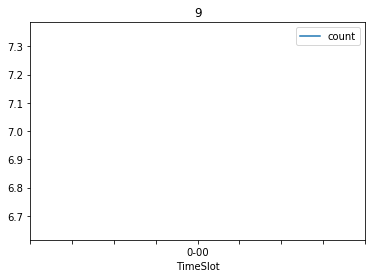

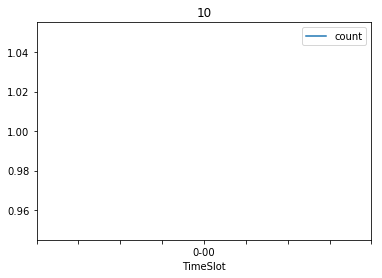

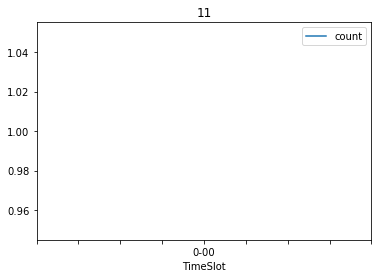

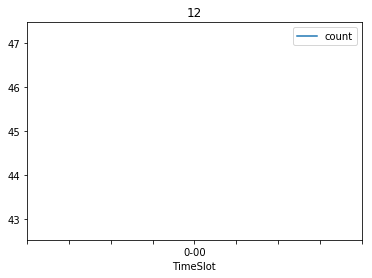

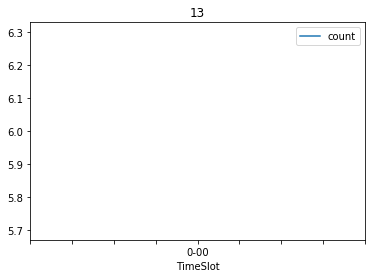

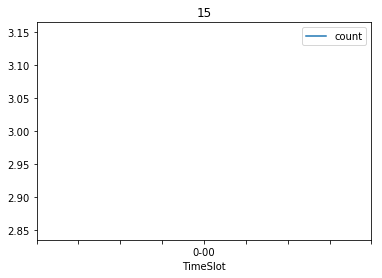

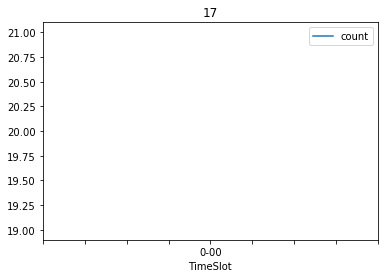

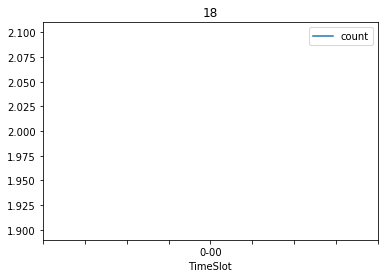

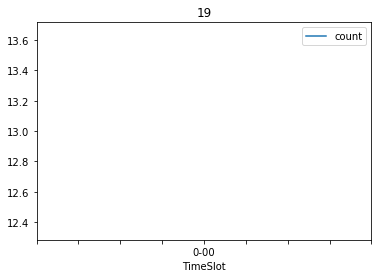

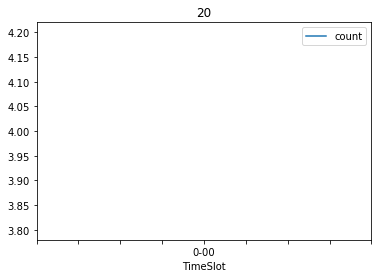

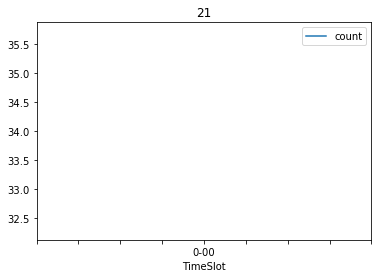

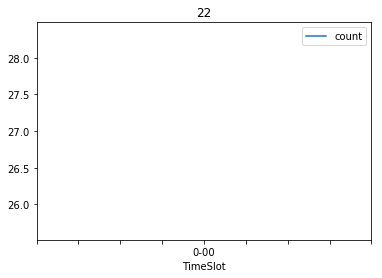

In [5]:
#df.plot(x='TimeSlot', y='count')

for i, group in df[0:20].groupby('UserID'):
    plt.figure()
    group.plot(x='TimeSlot', y='count', title=str(i))

In [306]:
fig, ax = plt.subplots()
labels = []
for key, grp in df.groupby(['UserID'][0:5]):
    ax = grp.plot(ax=ax, kind='line', x='TimeSlot', y='count', c=key)
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

KeyboardInterrupt: 

ValueError: Invalid RGBA argument: 1